In [ ]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import urllib
import datetime as dt

def buy_plot(df_market, df_operation):
    plt.figure(figsize=(12, 6))
    plt.plot(df_market.index, df_market['close'], label='Market Close Price', color='blue')
    # plt.scatter(df_operation.index, df_operation['Decision'], label='Buy Operations', color='green', marker='^')
    # if Decision == 1: buy, else if == -1: sell
    buy_operations = df_operation[df_operation['Decision'] == 1]
    sell_operations = df_operation[df_operation['Decision'] == -1]
    # mark at close price
    buy_operations['Decision'] = df_market.loc[buy_operations.index, 'close']
    sell_operations['Decision'] = df_market.loc[sell_operations.index, 'close']
    plt.scatter(buy_operations.index, buy_operations['Decision'], label='Buy Operations', color='green', marker='^')
    plt.scatter(sell_operations.index, sell_operations['Decision'], label='Sell Operations', color='red', marker='v')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Buy Operations on Market Close Price')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'./graphics/performance_comparison_{ticker}.pdf')
    plt.show()

def getStockMarketData(ticker, api_key = '4MFYSPOPV210V5WT'):
    if not os.path.exists(f'./data/stock_market_data-{ticker}.csv'):
        # ====================== Loading Data from Alpha Vantage ==================================


        # JSON file with all the stock market data for AAL from the last 20 years
        url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

        # Save data to this file
        file_to_save = './data/stock_market_data-%s.csv'%ticker

        # If you haven't already saved data,
        # Go ahead and grab the data from the url
        # And store date, low, high, volume, close, open values to a Pandas DataFrame
        if not os.path.exists(file_to_save):
            with urllib.request.urlopen(url_string) as url:
                data = json.loads(url.read().decode())
                # extract stock market data
                data = data['Time Series (Daily)']
                df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
                for k,v in data.items():
                    date = dt.datetime.strptime(k, '%Y-%m-%d')
                    data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                                float(v['4. close']),float(v['1. open'])]
                    df.loc[-1,:] = data_row
                    df.index = df.index + 1
            print('Data saved to : %s'%file_to_save)        
            df.to_csv(file_to_save)

    else:
        # If you have already saved data, just load it from the file
        df = pd.read_csv(f'./data/stock_market_data-{ticker}.csv', parse_dates=['timestamp'])
        df.set_index('timestamp', inplace=True)
    return df

def getOperation(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Operation file {file_path} does not exist.")
    
    df = pd.read_csv(file_path, parse_dates=['timestamp'])
    df.set_index('timestamp', inplace=True)
    return df

def calculate_strategy_returns(df_market, df_operation):
    """
    Calculate strategy returns based on actual trading operations
    """
    # Ensure we have matching dates
    df_market = df_market.copy()
    df_operation = df_operation.copy()
    
    # Calculate daily market returns
    df_market['return_rate'] = df_market['close'].pct_change()
    
    # Add market close prices to operation dataframe
    df_operation['market_close'] = df_market.loc[df_operation.index, 'close']
    
    # Calculate position changes and portfolio value
    df_operation['position_change'] = 0  # Net position change (positive for buy, negative for sell)
    df_operation['cash_flow'] = 0  # Cash flow (negative for buy, positive for sell)
    df_operation['total_position'] = 0  # Total shares held
    df_operation['portfolio_value'] = 0  # Total portfolio value
    df_operation['cash'] = 100000  # Starting cash (adjust as needed)
    
    current_position = 0
    current_cash = 100000  # Starting cash
    
    for i, (date, row) in enumerate(df_operation.iterrows()):
        decision = row['Decision']
        hands = row['Hands']
        price = row['market_close']
        
        if decision == 1:  # Buy
            shares_bought = hands
            cost = shares_bought * price
            if current_cash >= cost:  # Check if we have enough cash
                current_position += shares_bought
                current_cash -= cost
                df_operation.loc[date, 'position_change'] = shares_bought
                df_operation.loc[date, 'cash_flow'] = -cost
        
        elif decision == -1:  # Sell
            shares_sold = min(hands, current_position)  # Can't sell more than we have
            revenue = shares_sold * price
            current_position -= shares_sold
            current_cash += revenue
            df_operation.loc[date, 'position_change'] = -shares_sold
            df_operation.loc[date, 'cash_flow'] = revenue
        
        df_operation.loc[date, 'total_position'] = current_position
        df_operation.loc[date, 'cash'] = current_cash
        df_operation.loc[date, 'portfolio_value'] = current_cash + current_position * price
    
    # Calculate daily returns for the strategy
    df_operation['strategy_return'] = df_operation['portfolio_value'].pct_change()
    
    # Calculate cumulative returns
    df_market['cumulative_return'] = (1 + df_market['return_rate'].fillna(0)).cumprod()
    df_operation['cumulative_strategy_return'] = (1 + df_operation['strategy_return'].fillna(0)).cumprod()
    
    return df_market, df_operation

def plot_performance_comparison(df_market, df_operation, ticker):
    global slug
    """
    Plot market vs strategy performance
    """
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Price and operations
    plt.subplot(3, 1, 1)
    plt.plot(df_market.index, df_market['close'], label='Market Close Price', color='blue', alpha=0.7)
    
    buy_operations = df_operation[df_operation['Decision'] == 1]
    sell_operations = df_operation[df_operation['Decision'] == -1]
    
    if not buy_operations.empty:
        plt.scatter(buy_operations.index, buy_operations['market_close'], 
                   label='Buy Operations', color='green', marker='^', s=100, zorder=5)
    if not sell_operations.empty:
        plt.scatter(sell_operations.index, sell_operations['market_close'], 
                   label='Sell Operations', color='red', marker='v', s=100, zorder=5)
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{ticker} - Trading Operations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Portfolio value and position
    plt.subplot(3, 1, 2)
    plt.plot(df_operation.index, df_operation['portfolio_value'], 
             label='Portfolio Value', color='purple', linewidth=2)
    plt.plot(df_operation.index, df_operation['cash'], 
             label='Cash', color='orange', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.title('Portfolio Components')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Cumulative returns comparison
    plt.subplot(3, 1, 3)
    
    # Align the market data to strategy dates for fair comparison
    strategy_dates = df_operation.index
    market_aligned = df_market.loc[df_market.index.isin(strategy_dates)]
    
    # Normalize both to start at 1 for comparison
    market_cumret = (1 + market_aligned['return_rate'].fillna(0)).cumprod()
    strategy_cumret = df_operation['cumulative_strategy_return']
    
    plt.plot(market_aligned.index, market_cumret, 
             label='Market Cumulative Return', color='blue', linewidth=2)
    plt.plot(df_operation.index, strategy_cumret, 
             label='Strategy Cumulative Return', color='red', linewidth=2)
    
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title(f'Cumulative Return Comparison: {ticker}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'./graphics/performance_comparison_{ticker}_{slug}.pdf')
    plt.show()
    
    # Print performance metrics
    final_market_return = market_cumret.iloc[-1] - 1
    final_strategy_return = strategy_cumret.iloc[-1] - 1
    
    print(f"\n=== Performance Summary ===")
    print(f"Market Return: {final_market_return:.2%}")
    print(f"Strategy Return: {final_strategy_return:.2%}")
    print(f"Outperformance: {final_strategy_return - final_market_return:.2%}")
    print(f"Final Portfolio Value: ${df_operation['portfolio_value'].iloc[-1]:,.2f}")
    print(f"Final Cash: ${df_operation['cash'].iloc[-1]:,.2f}")
    print(f"Final Position: {df_operation['total_position'].iloc[-1]:,.0f} shares")

def calculate_strategy_returns_normalized(df_market, df_operation):
    """
    Calculate strategy returns with normalization to first trading day
    """
   # Ensure we have matching dates
    df_market = df_market.copy()
    df_operation = df_operation.copy()
    
    # Calculate daily market returns
    df_market['return_rate'] = df_market['close'].pct_change()
    
    # Add market close prices to operation dataframe
    df_operation['market_close'] = df_market.loc[df_operation.index, 'close']
    
    # Calculate position changes and portfolio value
    df_operation['position_change'] = 0  # Net position change (positive for buy, negative for sell)
    df_operation['cash_flow'] = 0  # Cash flow (negative for buy, positive for sell)
    df_operation['total_position'] = 0  # Total shares held
    df_operation['portfolio_value'] = 0  # Total portfolio value
    df_operation['cash'] = 100000  # Starting cash (adjust as needed)
    
    current_position = 0
    current_cash = 100000  # Starting cash
    
    for i, (date, row) in enumerate(df_operation.iterrows()):
        decision = row['Decision']
        hands = row['Hands']
        price = row['market_close']
        
        if decision == 1:  # Buy
            shares_bought = hands
            cost = shares_bought * price
            if current_cash >= cost:  # Check if we have enough cash
                current_position += shares_bought
                current_cash -= cost
                df_operation.loc[date, 'position_change'] = shares_bought
                df_operation.loc[date, 'cash_flow'] = -cost
        
        elif decision == -1:  # Sell
            shares_sold = min(hands, current_position)  # Can't sell more than we have
            revenue = shares_sold * price
            current_position -= shares_sold
            current_cash += revenue
            df_operation.loc[date, 'position_change'] = -shares_sold
            df_operation.loc[date, 'cash_flow'] = revenue
        
        df_operation.loc[date, 'total_position'] = current_position
        df_operation.loc[date, 'cash'] = current_cash
        df_operation.loc[date, 'portfolio_value'] = current_cash + current_position * price
    
    # Calculate daily returns for the strategy
    df_operation['strategy_return'] = df_operation['portfolio_value'].pct_change()
    
    # Calculate cumulative returns
    df_market['cumulative_return'] = (1 + df_market['return_rate'].fillna(0)).cumprod()
    df_operation['cumulative_strategy_return'] = (1 + df_operation['strategy_return'].fillna(0)).cumprod()
    
    # NORMALIZE to first operation date for fair comparison
    first_op_date = df_operation.index[0]
    if first_op_date in df_market.index:
        market_base = df_market.loc[first_op_date, 'cumulative_return']
        strategy_base = df_operation.loc[first_op_date, 'cumulative_strategy_return']
        
        # Normalize both to start at 1.0 on the first trading day
        df_market['cumulative_return_normalized'] = df_market['cumulative_return'] / market_base
        df_operation['cumulative_strategy_return_normalized'] = df_operation['cumulative_strategy_return'] / strategy_base
    
    return df_market, df_operation

def plot_performance_comparison_normalized(df_market, df_operation, ticker):
    global slug
    # [previous subplot code remains the same]
    
    # Subplot 3: Normalized cumulative returns comparison
    plt.subplot(3, 1, 3)
    
    # Use normalized returns for fair comparison
    strategy_dates = df_operation.index
    market_aligned = df_market.loc[df_market.index.isin(strategy_dates)]
    
    plt.plot(market_aligned.index, market_aligned['cumulative_return_normalized'], 
             label='Market Cumulative Return (Normalized)', color='blue', linewidth=2)
    plt.plot(df_operation.index, df_operation['cumulative_strategy_return_normalized'], 
             label='Strategy Cumulative Return (Normalized)', color='red', linewidth=2)
    
    plt.xlabel('Date')
    plt.ylabel('Normalized Cumulative Return')
    plt.title(f'Normalized Cumulative Return Comparison: {ticker}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()    
    plt.savefig(f'./graphics/performance_comparison_{ticker}_{slug}.pdf')
    plt.show()

In [37]:

# Usage
result_file = 'results/my-new-workspace-27090636_DJIA.csv'

ticker = result_file.split('_')[-1].split('.')[0]  # Extract ticker from result file name
slug = result_file.split('_')[-2].split('-')[-1]
df_market = getStockMarketData(ticker)
df_operation = getOperation(result_file)

# Filter market data to match operation date range
date_range = pd.date_range(start=df_operation.index.min(), end=df_operation.index.max(), freq='B')
df_market = df_market[df_market.index.isin(date_range)]
print(df_market.describe())

               open          high           low         close  volume
count    252.000000    252.000000    252.000000    252.000000   263.0
mean   40323.128611  40323.128611  40323.128611  40323.128611     0.0
std     2053.077767   2053.077767   2053.077767   2053.077767     0.0
min    37266.670000  37266.670000  37266.670000  37266.670000     0.0
25%    38720.710000  38720.710000  38720.710000  38720.710000     0.0
50%    39562.480000  39562.480000  39562.480000  39562.480000     0.0
75%    42088.877500  42088.877500  42088.877500  42088.877500     0.0
max    45014.040000  45014.040000  45014.040000  45014.040000     0.0


/tmp/ipykernel_3143799/3772313473.py:215: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_market['return_rate'] = df_market['close'].pct_change()
/tmp/ipykernel_3143799/3772313473.py:257: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_operation['strategy_return'] = df_operation['portfolio_value'].pct_change()


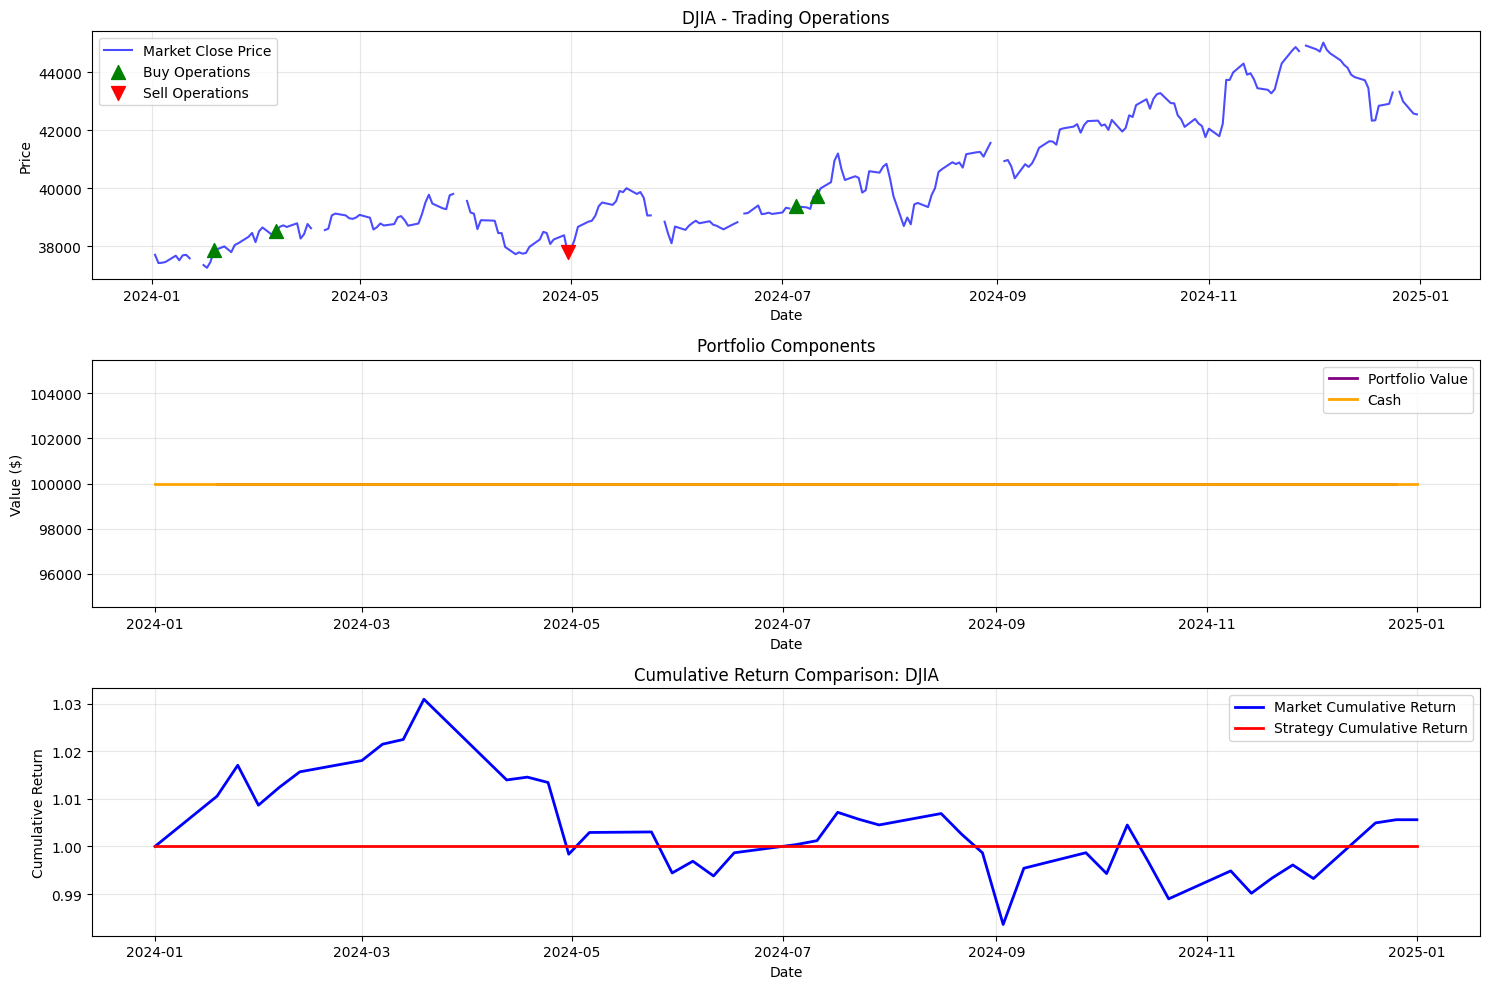


=== Performance Summary ===
Market Return: 0.56%
Strategy Return: 0.00%
Outperformance: -0.56%
Final Portfolio Value: $nan
Final Cash: $100,000.00
Final Position: 0 shares


In [38]:

# Calculate returns with the improved method
df_market, df_operation = calculate_strategy_returns_normalized(df_market, df_operation)

# Plot comprehensive analysis
plot_performance_comparison(df_market, df_operation, ticker)

            Decision  Hands  market_close  position_change  cash_flow  \
timestamp                                                               
2024-01-01         1    300           NaN                0          0   
2024-01-19         1    300      37863.80                0          0   
2024-01-25         0      0      38049.13                0          0   
2024-01-31         0      0      38150.30                0          0   
2024-02-06         1    300      38521.36                0          0   
2024-02-12         0      0      38797.38                0          0   
2024-03-01         0      0      39087.38                0          0   
2024-03-07         0      0      38791.35                0          0   
2024-03-13         0      0      39043.32                0          0   
2024-03-19         0      0      39110.76                0          0   
2024-03-25         0      0      39313.64                0          0   
2024-04-12         0      0      37983.24          

/tmp/ipykernel_3143799/3772313473.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_operations['Decision'] = df_market.loc[buy_operations.index, 'close']
/tmp/ipykernel_3143799/3772313473.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_operations['Decision'] = df_market.loc[sell_operations.index, 'close']


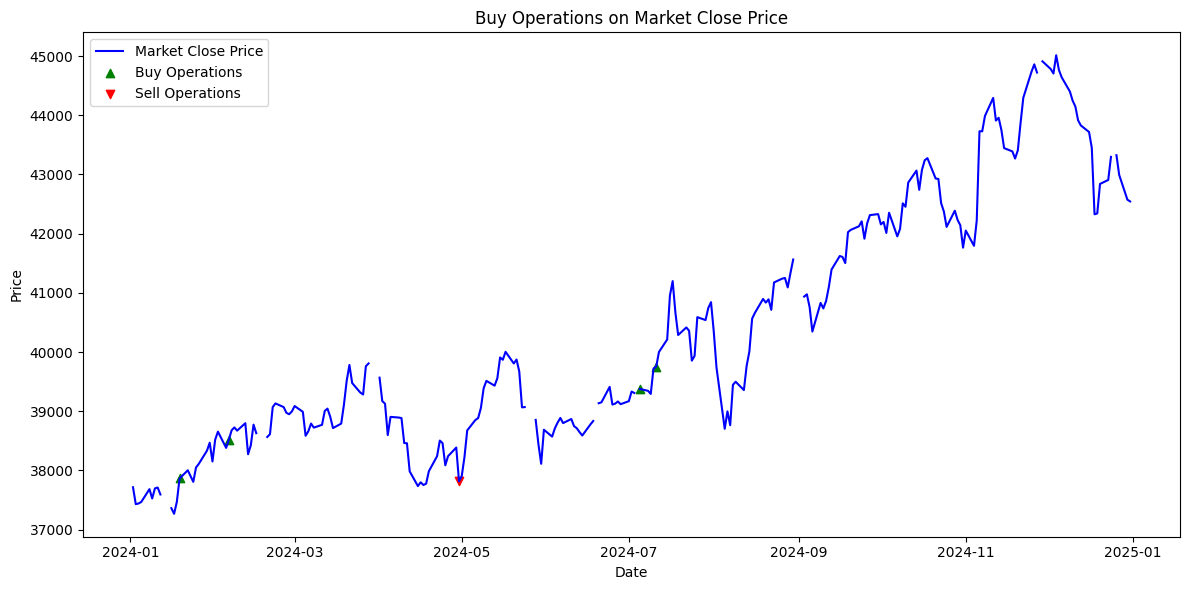

In [39]:

# Get stock market data
df_market = getStockMarketData(ticker)


date_range = pd.date_range(start=df_operation.index.min(), end=df_operation.index.max(), freq='B')
df_market = df_market[df_market.index.isin(date_range)]
print(df_operation)

# Generate buy plot
buy_plot(df_market, df_operation)

/tmp/ipykernel_3143799/1569811240.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_market['return_rate'] = df_market['close'].pct_change()
/tmp/ipykernel_3143799/1569811240.py:6: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df_operation['position'] = df_operation['Decision'].replace(0, method='ffill').fillna(0)
/tmp/ipykernel_3143799/1569811240.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_operation['strategy_return'] = df_operation['market_close'].pct_change() * df_operation['position'].shift(1).fillna(0)


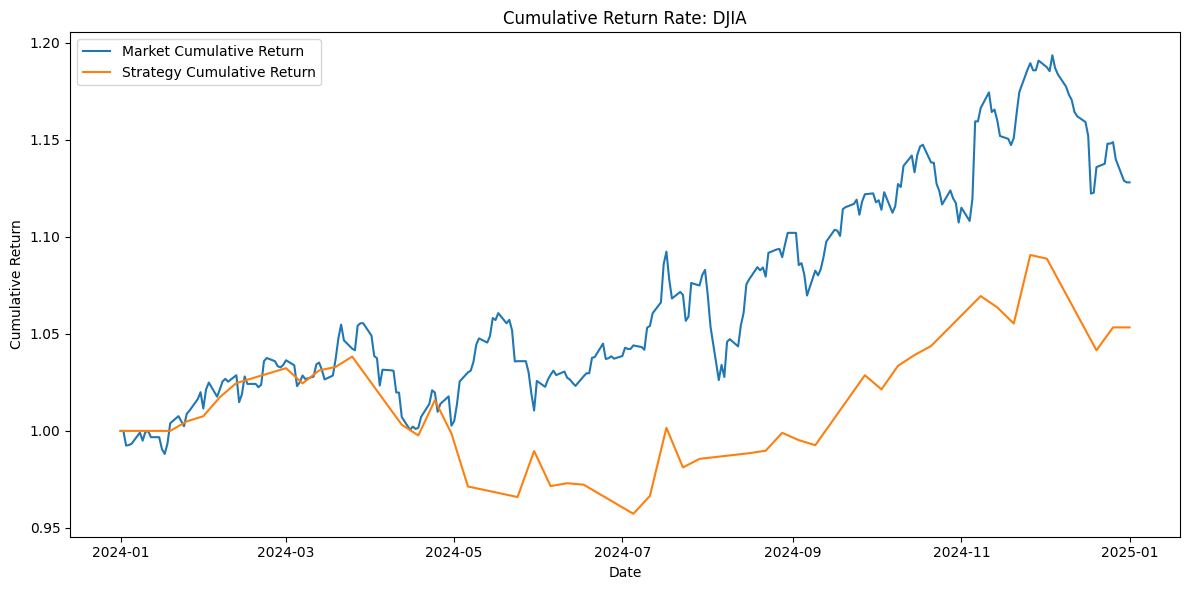

In [40]:
# Calculate daily return rate for the market
df_market['return_rate'] = df_market['close'].pct_change()

# Calculate strategy return rate based on operations
df_operation['market_close'] = df_market.loc[df_operation.index, 'close']
df_operation['position'] = df_operation['Decision'].replace(0, method='ffill').fillna(0)
df_operation['strategy_return'] = df_operation['market_close'].pct_change() * df_operation['position'].shift(1).fillna(0)

# Cumulative returns
df_market['cumulative_return'] = (1 + df_market['return_rate'].fillna(0)).cumprod()
df_operation['cumulative_strategy_return'] = (1 + df_operation['strategy_return'].fillna(0)).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df_market.index, df_market['cumulative_return'], label='Market Cumulative Return')
plt.plot(df_operation.index, df_operation['cumulative_strategy_return'], label='Strategy Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title(f'Cumulative Return Rate: {ticker}')
plt.legend()
# plt.xlim(df_operation.index.min(), df_operation.index.max())
plt.tight_layout()
plt.savefig(f'./graphics/Cumulative_Return_{ticker}_{slug}.pdf')
plt.show()
